# What it takes to be Data Scientist?

in this notebook i will try to answer questions for anyone who want to be data scientist.



1. what data science stack we need to have?
2. what data science stack that pay high?
3. how much your annual income if you have given stack skill?
4. what country give the best job satisfaction for data scientist?



## Data Understanding
To answer the questions above, luckily we have 2020 Developer Survey from Stackoverflow public data.

### Load Needed Libraries for This Project

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We load Pandas, Numpy, and pyplot for this project. This libraries will be heavily used for this project

### Load the Data and Filter Needed Columns
We load the data from csv file and take only desired column for this project

As you can see below, this table already have our needed data like the database developer used, what developer type he/she is, etc.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/datasets/stackoverflow_survey_2020/survey_results_public.csv')
desired_column = ['MainBranch', 'ConvertedComp', 'Country', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWLearn', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro']
df = df[desired_column]
df.head()

,MainBranch,ConvertedComp,Country,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWLearn,PlatformDesireNextYear,PlatformWorkedWith,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WorkWeekHrs,YearsCode,YearsCodePro
0,I am a developer by profession,NaN,Germany,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Once a year,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,50.0,36,27
1,I am a developer by profession,NaN,United Kingdom,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Once a year,iOS;Kubernetes;Linux;MacOS,iOS,"Computer science, computer engineering, or sof...",NaN,NaN,NaN,7,4
2,I code primarily as a hobby,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,Once a decade,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
3,I am a developer by profession,NaN,Albania,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,NaN,NaN,NaN,NaN,Once a year,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,40.0,7,4
4,"I used to be a developer by profession, but no...",NaN,United States,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Java;Ruby;Scala,HTML/CSS;Ruby;SQL,Ansible;Chef,Ansible,Once a year,Docker;Google Cloud Platform;Heroku;Linux;Windows,AWS;Docker;Linux;MacOS;Windows,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,NaN,15,8


## Sliced Database for Trial (comment this line when you are ready)

In [4]:
# df = df.iloc[:200,:]

## Data Preparation
Before we can do more with this data, we have to clean the data first

### Filter Only Developer Respondent
Since we are only interested in a person who is developer, we only take "I am a developer by profession" answer in MainBranch column.

In [5]:
df = df[df['MainBranch'] == 'I am a developer by profession']

### Dummify Column with List Values
As you can see in the table, there are many data that are stringified list. We need to change this raw string value into separated column so we can analyze it

#### Create Functions to Convert List to Dummies
First step, we create functions to do so


In [6]:
def add_list_to_df(df, arr, prefix):
  '''
  INPUT:
  df - target df to be added
  arr - list of string to be added to dataframe
  prefix - column prefix

  OUTPUT:
  new_df - dataframe with added dummies column
  '''

  append_dict = {}
  for col_name in arr:
    col_name = prefix + '_' + col_name
    
    #add new column in dataframe
    if col_name not in list(df.columns):
      df[col_name] = [False]*df.shape[0]
    
    append_dict[col_name] = True
  
  #add new row
  df = df.append(append_dict, ignore_index=True, verify_integrity=True)

  return df

In [7]:
def separate_column_list(df, col_name, list_sep, prefix=None):
  '''
  INPUT:
  df - pandas dataframe
  col_name - name of column which contain list that want to be separated
  list_sep - character used to separate object in the list
  prefix - prefix for the new column

  OUTPUT:
  new_df - new dataframe with separated column only
  '''
  if prefix == None:
    prefix = col_name
  
  target_df = df[col_name]
  new_df = pd.DataFrame()

  for i in range(df.shape[0]):
    raw_str = target_df.iat[i]
    if type(raw_str) != str:
      continue
    str_list = raw_str.split(list_sep)
    new_df = add_list_to_df(new_df, str_list, prefix)
  
  return new_df

#### Create Util Functions for Future Use

In [19]:
def get_dummy_columns_name(raw_col_name, dummy_columns):
  '''
  INPUT:
  raw_col_name - name of column before it dummified
  list_of_dummy_column - names of dummy column

  OUTPUT:
  dummy_column_names - list of column name that come from raw_col_name
  '''
  dummy_column_names = []
  for dummy_column in dummy_columns:
    if raw_col_name in dummy_column:
      dummy_column_names.append(dummy_column)
  
  return dummy_column_names

#### List of Dummified Columns
We save the list of each column that have the stringified list value

In [20]:
stringified_list_columns_name = ['DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType',
  'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear',
  'MiscTechWorkedWith', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'WebframeDesireNextYear',
  'WebframeWorkedWith']

#### Run the Functions for All the Columns
Then we iterate through dummified_columns to dummify the given columns



In [9]:
for column in dummified_columns:
  df = pd.concat([df.drop(axis=1, columns=column), separate_column_list(df, column, ';')],
                  axis=1)

#### Dummified Dataframe Result
you can see the dummfied columns at the rightmost of the table below

In [10]:
df.head()

,MainBranch,ConvertedComp,Country,EdLevel,Employment,NEWLearn,UndergradMajor,WorkWeekHrs,YearsCode,YearsCodePro,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Couchbase,DatabaseDesireNextYear_IBM DB2,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_Redis,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Cassandra,DatabaseWorkedWith_Couchbase,"DevType_Developer, desktop or enterprise applications","DevType_Developer, full-stack",...,PlatformWorkedWith_Heroku,PlatformWorkedWith_Google Cloud Platform,PlatformWorkedWith_Kubernetes,PlatformWorkedWith_MacOS,PlatformWorkedWith_Arduino,PlatformWorkedWith_Slack Apps and Integrations,PlatformWorkedWith_Microsoft Azure,PlatformWorkedWith_IBM Cloud or Watson,WebframeDesireNextYear_ASP.NET Core,WebframeDesireNextYear_React.js,WebframeDesireNextYear_Django,WebframeDesireNextYear_Vue.js,WebframeDesireNextYear_Angular.js,WebframeDesireNextYear_Flask,WebframeDesireNextYear_jQuery,WebframeDesireNextYear_Angular,WebframeDesireNextYear_ASP.NET,WebframeDesireNextYear_Gatsby,WebframeDesireNextYear_Express,WebframeDesireNextYear_Spring,WebframeDesireNextYear_Ruby on Rails,WebframeDesireNextYear_Laravel,WebframeDesireNextYear_Symfony,WebframeDesireNextYear_Drupal,WebframeWorkedWith_ASP.NET,WebframeWorkedWith_ASP.NET Core,WebframeWorkedWith_Flask,WebframeWorkedWith_jQuery,WebframeWorkedWith_Angular,WebframeWorkedWith_Angular.js,WebframeWorkedWith_Django,WebframeWorkedWith_React.js,WebframeWorkedWith_Vue.js,WebframeWorkedWith_Gatsby,WebframeWorkedWith_Spring,WebframeWorkedWith_Express,WebframeWorkedWith_Ruby on Rails,WebframeWorkedWith_Symfony,WebframeWorkedWith_Laravel,WebframeWorkedWith_Drupal
0,I am a developer by profession,NaN,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",Once a year,"Computer science, computer engineering, or sof...",50.0,36,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,I am a developer by profession,NaN,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Once a year,"Computer science, computer engineering, or sof...",NaN,7,4,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I am a developer by profession,NaN,Albania,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,Once a year,"Computer science, computer engineering, or sof...",40.0,7,4,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.

#### Dummified Columns Result
After running the data above, we need the names of each dummified columns for next step of processing

In [22]:
dummified_columns_result = []
for stringified_list_column_name in stringified_list_columns_name:
  dummified_columns_result.extend(get_dummy_columns_name(stringified_list_column_name,list(df.columns)))

### Last Step Clearing
Some of the dummified column still need to be cleared, so i clear with the below steps

#### Change Float Value to Boolean in Dummified Columns

In [12]:
for col_name in dummified_columns_result:
  df[col_name] = df[col_name].fillna(0)
  df[col_name] = df[col_name].replace({0.0: False, 1.0: True})
df.head()

,MainBranch,ConvertedComp,Country,EdLevel,Employment,NEWLearn,UndergradMajor,WorkWeekHrs,YearsCode,YearsCodePro,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Couchbase,DatabaseDesireNextYear_IBM DB2,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_Redis,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Cassandra,DatabaseWorkedWith_Couchbase,"DevType_Developer, desktop or enterprise applications","DevType_Developer, full-stack",...,PlatformWorkedWith_Heroku,PlatformWorkedWith_Google Cloud Platform,PlatformWorkedWith_Kubernetes,PlatformWorkedWith_MacOS,PlatformWorkedWith_Arduino,PlatformWorkedWith_Slack Apps and Integrations,PlatformWorkedWith_Microsoft Azure,PlatformWorkedWith_IBM Cloud or Watson,WebframeDesireNextYear_ASP.NET Core,WebframeDesireNextYear_React.js,WebframeDesireNextYear_Django,WebframeDesireNextYear_Vue.js,WebframeDesireNextYear_Angular.js,WebframeDesireNextYear_Flask,WebframeDesireNextYear_jQuery,WebframeDesireNextYear_Angular,WebframeDesireNextYear_ASP.NET,WebframeDesireNextYear_Gatsby,WebframeDesireNextYear_Express,WebframeDesireNextYear_Spring,WebframeDesireNextYear_Ruby on Rails,WebframeDesireNextYear_Laravel,WebframeDesireNextYear_Symfony,WebframeDesireNextYear_Drupal,WebframeWorkedWith_ASP.NET,WebframeWorkedWith_ASP.NET Core,WebframeWorkedWith_Flask,WebframeWorkedWith_jQuery,WebframeWorkedWith_Angular,WebframeWorkedWith_Angular.js,WebframeWorkedWith_Django,WebframeWorkedWith_React.js,WebframeWorkedWith_Vue.js,WebframeWorkedWith_Gatsby,WebframeWorkedWith_Spring,WebframeWorkedWith_Express,WebframeWorkedWith_Ruby on Rails,WebframeWorkedWith_Symfony,WebframeWorkedWith_Laravel,WebframeWorkedWith_Drupal
0,I am a developer by profession,NaN,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",Once a year,"Computer science, computer engineering, or sof...",50.0,36,27,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,I am a developer by profession,NaN,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Once a year,"Computer science, computer engineering, or sof...",NaN,7,4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,I am a developer by pr

#### Filter Only Data Related Respondent
Since we are only interested in Data Science, Data Analytics, ML Engineer respondents, we will only keep the row who have **'DevType_Data or business analyst'** or **'DevType_Data scientist or machine learning specialist'** value

In [13]:
df = df[(df['DevType_Data scientist or machine learning specialist'] | df['DevType_Data or business analyst'])].dropna(subset=['MainBranch'])
df[['MainBranch', 'DevType_Data scientist or machine learning specialist', 'DevType_Data or business analyst']].head()

,MainBranch,DevType_Data scientist or machine learning specialist,DevType_Data or business analyst
30,I am a developer by profession,False,True
33,I am a developer by profession,True,False
44,I am a developer by profession,False,True
49,I am a developer by profession,True,False
51,I am a developer by profession,True,True


## Descriptive Analysis
Now our data is cleaned, before jumping into modelling, I'm trying to create some descriptive analytic from our dataframe

### Most Popular Stack Among Data Scientist

First, we get the column name that's related to the stack that mostly used by data scientist and save it to *dummified_popular_stack_columns*

In [ ]:
raw_col_list = ['DatabaseWorkedWith', 'LanguageWorkedWith', 'MiscTechWorkedWith']
popular_stack_dummy_columns = []
for raw_col in raw_col_list:
  popular_stack_dummy_columns.extend(get_dummy_columns_name(raw_col, list(df.columns)))

Second, we slice the dataframe only at the column in *popular_stack_dummy_columns*

In [62]:
popular_stack_df = df[dummified_popular_stack_columns]
popular_stack_df.head()

,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_Redis,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Cassandra,DatabaseWorkedWith_Couchbase,LanguageWorkedWith_C#,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_Swift,LanguageWorkedWith_Java,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_Kotlin,LanguageWorkedWith_R,LanguageWorkedWith_VBA,LanguageWorkedWith_Perl,LanguageWorkedWith_C++,LanguageWorkedWith_C,LanguageWorkedWith_Haskell,LanguageWorkedWith_Ruby,LanguageWorkedWith_Rust,LanguageWorkedWith_Dart,LanguageWorkedWith_Scala,LanguageWorkedWith_Julia,LanguageWorkedWith_Assembly,LanguageWorkedWith_Go,LanguageWorkedWith_Objective-C,MiscTechWorkedWith_.NET,MiscTechWorkedWith_.NET Core,MiscTechWorkedWith_React Native,MiscTechWorkedWith_Ansible,MiscTechWorkedWith_Pandas,MiscTechWorkedWith_Node.js,MiscTechWorkedWith_TensorFlow,MiscTechWorkedWith_Torch/PyTorch,MiscTechWorkedWith_Unity 3D,MiscTechWorkedWith_Teraform,MiscTechWorkedWith_Hadoop,MiscTechWorkedWith_Flutter,MiscTechWorkedWith_Cordova,MiscTechWorkedWith_Keras,MiscTechWorkedWith_Xamarin,MiscTechWorkedWith_Unreal Engine,MiscTechWorkedWith_Apache Spark,MiscTechWorkedWith_Puppet,MiscTechWorkedWith_Chef
30,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
33,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False
44,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
49,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
51,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False


I create sum of each stack and sort it by count and take only top 30

In [68]:
sorted_popular_stack_df = popular_stack_df.sum().sort_values(ascending=False).head(30)

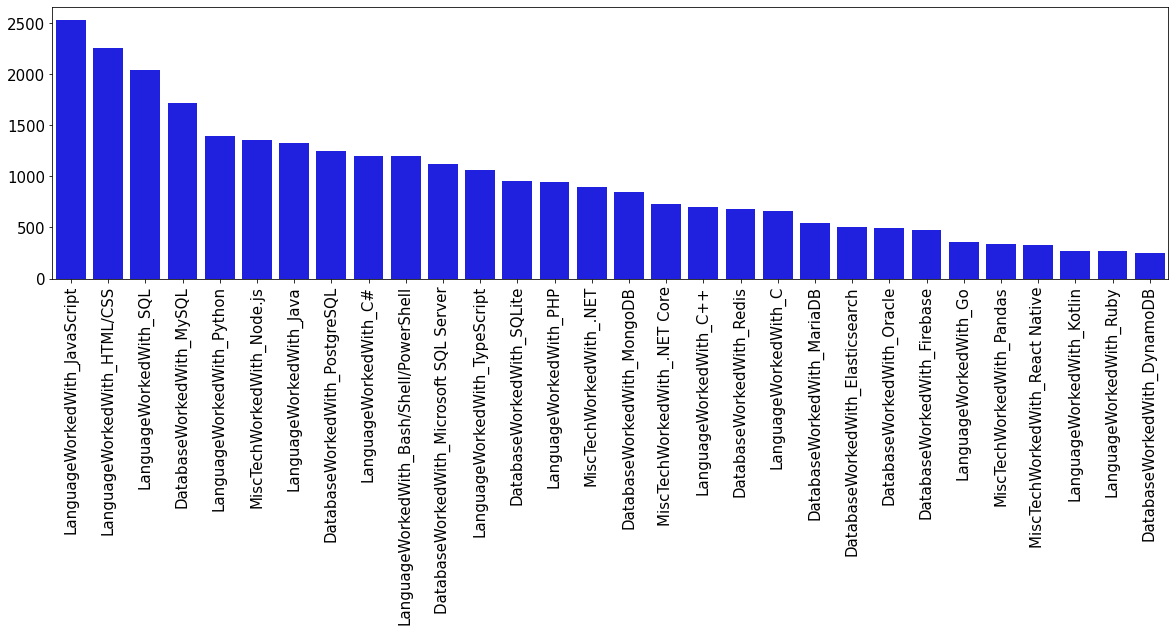

In [75]:
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical', fontsize=15.0)
plt.yticks(fontsize=15.0)
sns.barplot(x=sorted_popular_stack_df.index, y=sorted_popular_stack_df, color='blue')
plt.show()

As you can see, javascript and HTML/CSS is the most common stack to work with. But when it comes to data-related stack, SQL is the most common. It infers that having SQL skill is the most important in this field